In [1]:
using VUE
using Plots
using Distributions
using JLD
gr(display_type=:inline)

┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/M4dfL/src/backends.jl:37


[ Info: GR


Plots.GRBackend()

# replication of Kiani & Shadlen 2009

In [2]:
fdefs=Defs(;dt=0.005,σ=1.0,tw1=1.0,tw2=1.0,tbar=0.9,xbar=3.,num_states=651,mr=3.0,
    zs=[-0.512,-0.256,-0.128,-0.064,-0.032,0.,0.032,0.064,0.128,0.256,0.512],
    ps=[1.,1.,1.,1.,1.,2,1.,1.,1.,1.,1.],
    runmed_width=7,runmed_width_inn=7);

In [3]:
k=8.
m=ModelParameters(k, 1.5, 0.95)

fix_RTs=fdefs.t_vec[findfirst(x->x .>= 0.1,fdefs.t_vec):end][1:2:end]
dist=Truncated(Exponential(0.1),0.1,0.9)
p_fix_RTs=diff(cdf.(dist,fdefs.t_vec))
t_NFix=length(fix_RTs)

V,D_fix,V_fix,DUR_fix,VUR_fix=decisionAreaFixed(m,fdefs,fix_RTs,p_fix_RTs;full=true);

In [4]:
# expand D fix
D_fix_ex=zeros(Int64,size(V))
DUR_fix_ex=zeros(Int64,size(V))
s=1
fix_RTs_plot=[]
for (i,rt) in enumerate(fix_RTs)
    e=round(Int64,rt / fdefs.dt)
    D_fix_ex[:,s:e].=D_fix[:,i]
    if i==1
        DUR_fix_ex[:,s:e].=4.
    else
        DUR_fix_ex[:,s:e].=DUR_fix[:,i]
    end
    s=e
    push!(fix_RTs_plot,e*fdefs.dt)
end

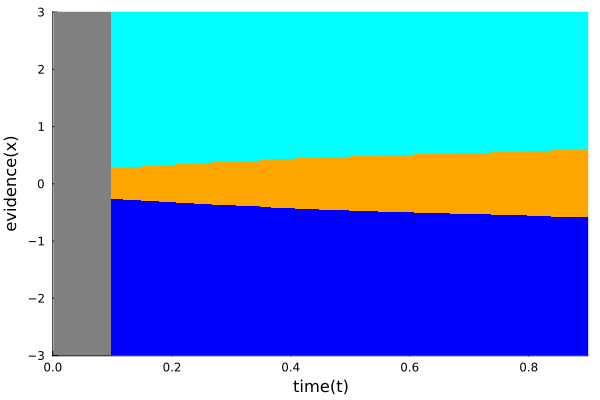

In [5]:
fig_DUR_fix=heatmap(fdefs.t_vec,fdefs.x_vec,Float64.(DUR_fix_ex),color=cgrad([:blue,:cyan,:orange,:grey]),clim=(1.,4.),
    xlim=(0.,maximum(fix_RTs)),legend=false,
    xlabel="time(t)",ylabel="evidence(x)",levels=4,label=["left","tright","UR","wait"])
# vline!(fix_RTs_plot,color=:black,label="fixed duration time",legend=true)

fig_DUR_fix

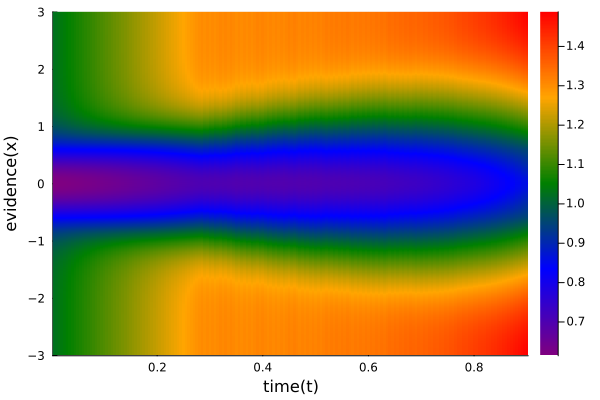

In [6]:
fig_V=heatmap(fdefs.t_vec,fdefs.x_vec,V,color=:rainbow,xlabel="time(t)",ylabel="evidence(x)",levels=4)
save("res_sim/kiani_structure.jld","t_vec",fdefs.t_vec,"x_vec",fdefs.x_vec,"DUR_fix_ex",DUR_fix_ex,"V",V)
fig_V

Evidence is supposed to be a common ddm.

$$
\frac{\partial }{\partial t}p(t,y)=-\mu \frac{\partial }{\partial y}p(t,y)+\frac{\sigma ^2}{2}\frac{\partial ^2}{\partial y^2}p(t,y)\\

\text{IC: }

p(0,y)=\delta (y-x)\\

\text{BC: }

p\left(t,h_2\right)=0,p\left(t,h_1\right)=0
$$


Transition probability density in $G\backslash \partial G$

$$
p(t,y)=\exp  \left(\frac{\mu  (y-x)}{\sigma ^2}-\frac{\mu ^2 t}{2 \sigma ^2}\right)
    \frac{2}{h_2-h_1}
    \sum _{n=1}^{\infty }
    \left\{
    \exp-\frac{(\pi  n)^2 \left(\sigma ^2 t\right)}{2 \left(h_2-h_1\right){}^2}
    \sin\frac{  n \pi \left(y-h_1\right)}{h_2-h_1}
    \sin\frac{  n \pi \left(x-h_1\right)}{h_2-h_1}
    \right\}
$$




In [7]:
"""
t: time
y: decision variable position
""" 
sigma2=1.
trans_prob(mu::Float64,t::Float64,y::Float64;x::Float64=0.,h::Float64=1.,nmax::Int64=100)=begin
    h1=-h;h2=h
    first_term=exp.(mu*(y-x)/sigma2-mu^2*t/(2*sigma2))*1/(h2-h1)
    n=1:nmax
    exppart=exp.(-(n .*π).^2 .*sigma2*t./(2*(h2-h1)^2))
    cospart=cos.((n .*π).*(y-x)/(h2-h1)) .- cos.((n .*π).*(y+x-2*h1)./(h2-h1))
    second_term=sum(exppart .* cospart)
    
    v=first_term*second_term
    return v # maximum([v,0.])
end

trans_prob (generic function with 1 method)

In [10]:
h=3.
b=decisionBound(DUR_fix)
prop_ur=zeros(fdefs.mid_z,t_NFix)
prop_correct=zeros(fdefs.mid_z,t_NFix)
prop_std_correct=zeros(fdefs.mid_z,t_NFix)
for (i,z) in enumerate(fdefs.zs[fdefs.mid_z:end])
    for (j,rt) in enumerate(fix_RTs)
        f(x::Float64)=trans_prob(k*z,rt,x;h=h)  
        
        # sure target
        tmp_ur=0.
        for x in fdefs.x_vec[b.inn_low[j]:b.inn_upp[j]]
            tmp_ur+=f(x)
        end
        tmp_l=0.;tmp_r=0.
        for x in fdefs.x_vec[1:b.inn_low[j]]
            tmp_l+=f(x)
        end
        for x in fdefs.x_vec[b.inn_upp[j]:end]
            tmp_r+=f(x)
        end
        
        prop_ur[i,j]=tmp_ur/(tmp_l+tmp_r+tmp_ur)
        prop_correct[i,j]=tmp_r/(tmp_l+tmp_r)
    
        # no sure target #
        
        tmp_l=0.;tmp_r=0.
        
        for x in fdefs.x_vec[1:fdefs.mid_state-1]
            tmp_l+=f(x)
        end


        for x in fdefs.x_vec[fdefs.mid_state+1:end]
            tmp_r+=f(x)
        end

        tmp_l+=f(fdefs.x_vec[fdefs.mid_state])/2
        tmp_r+=f(fdefs.x_vec[fdefs.mid_state])/2
        prop_std_correct[i,j]=tmp_r/(tmp_l+tmp_r)
    
    end

end

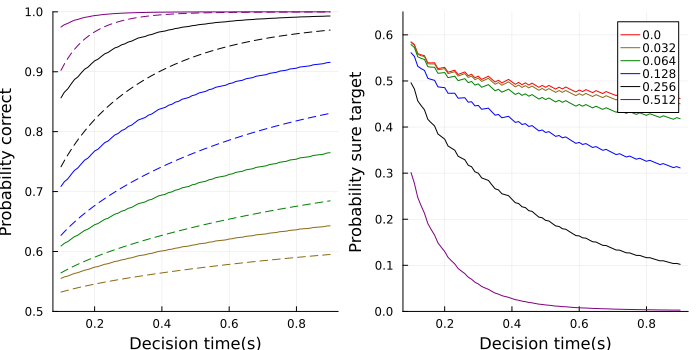

In [11]:
cs=[:red :goldenrod4 :green :blue :black :purple]
fig_acc=plot(fix_RTs,prop_correct[2:end,:]',
    legend=false,
    xlabel="Decision time(s)",ylabel="Probability correct",ylim=[0.5,1.0],c=cs[:,2:end])
plot!(fix_RTs,prop_std_correct[2:end,:]',linestyle=:dash,
    xlabel="Decision time(s)",ylabel="Probability correct",c=cs[:,2:end])

fig_sr=plot(fix_RTs,prop_ur',label=fdefs.zs[fdefs.mid_z:end]',
xlabel="Decision time(s)",ylabel="Probability sure target",c=cs,ylim=(0,0.65))

fig_acc_sr=plot(fig_acc,fig_sr,layout=(1,2),size=(700,350))
save("res_sim/kiani_result.jld",
    "fix_RTs",fix_RTs,
    "prop_correct",prop_correct,
    "prop_std_correct",prop_std_correct,
    "prop_ur",prop_ur
    )
fig_acc_sr